In [1]:
import os
import matplotlib
matplotlib.__version__

'3.5.1'

In [2]:
# !pip install -q ./pyansys_rl ./pyansys_gym --user --no-warn-script-location

In [3]:
import warnings
warnings.filterwarnings("ignore")
from uuid import uuid4
from pyansys_dqn import dqn, dqn_runner, qn_keras

# disable tensorflow warnings
import tensorflow as tf
# tf.logging.set_verbosity(tf.logging.ERROR)

<h1>Reinforcement Learning: DQN</h1>
<img src="media/DQN_clean.jpg" alt="Drawing" style="width: 800px;"/>

The DQN implementation is inspired by the famous paper [Mnih et al, 2014](https://www.nature.com/articles/nature14236).

The algorithm consists of two neural networks (NN) to accumulate the statistical information about optimal reward sequences. 
One NN, used for learning, is trained at every step by picking a random sample of experiences (state, action, reward)-tuples from an "experience buffer".  The buffer is filled from new experiences (old experiences are retired once the contents exceed capacity) as the agent trains.  At the outset, the buffer is pre-filled with experiences from an agent that behaves at random for a fixed number of steps.  The other NN, used for behavior, is just a snapshot of the first refreshed at fixed intervals and dictates what actions to take. 

Parameters used:
* Neural network size/topology:  [4, 32, 32, 2]
    * 4: for each components of the state ($x_{\text{cart}}, v_{\text{cart}}, \theta_{\text{pole}}, v_{\text{pole}}$)
    * 32: hidden layer 1 with 32 ReLU neurons
    * 32: hidden layer 2 with 32 ReLU neurons
    * 2: for each possible action with linear neurons [Left, Right]
* Neural network refresh rate: every timestep
* Buffer capacity: 40K experiences
* Buffer warmup: 1K experiences
* Sample size: 64 experiences per timestep
* $\varepsilon$: linear decay from 1 to .05 in 1000 timestep (.05 thereafter)
* $\gamma = .99$

## Learning Task:
Try to balance the pole up to 200 steps.  Declare success when the 10-episode average exceeds 196

Each learner will display a history of performance per episode, encoded as follows:

* e: episode number
* n: timesteps 
* x: max reward thus far
* r: reward
* v: avg reward (e.g., for last 10 steps)
* vx: max average reward
* nt: total timesteps thus far

In [4]:
from IPython.display import clear_output
from matplotlib import pyplot as plt
import collections
%matplotlib inline

class LivePlotter:
    def __init__(self):
        self.data = collections.defaultdict(list)
        self.figsize=(17,10)
        self.title='Training History'  
        
    def live_plot(self, episode, steps, r_tot, r_max, r_ave, r_ave_max, steps_tot):
        self.data['current'].append(r_tot)
        self.data['average'].append(r_ave)
        
        plt.figure(figsize=self.figsize)
        clear_output(wait=True)
        plt.plot(self.data['current'], label='current', color='orange', linestyle='dashed')
        plt.plot(self.data['average'], label='average', color='blue', linestyle='-')
        if r_ave > 196:
            plt.figure(1).text(0.95, 0.05, 'Success!', fontsize=50, color='gray', ha='right', va='bottom', alpha=0.5)
            
        plt.title(self.title)
        plt.grid(True)
        plt.xlabel('episode')
        plt.ylabel('reward')
        plt.legend(loc='center left') # the plot evolves to the right
        plt.ylim([0,200])
        plt.xlim([0,400])
        plt.show();

### "Native" environment from OpenAI
Here we take practice swings running reinforcement learning on a known open source implementation of the classic control problem.
You should see the episode rewards and their running average increase until they arrive at the training objective (196 for 10-episode average):

In [5]:
env_name = 'CartPole-v0'

output_path_gym = os.path.join(os.getcwd(), 'gym_cartpole_results', str(uuid4())) 
output_name_gym = 'gym_cartpole_00'

if not os.path.exists(output_path_gym):
    os.makedirs(output_path_gym)
print(f'Writing model in: {output_path_gym}')

Writing model in: c:\Users\gayuso\Other_Projects\ML_RL_Cartpole\gym_cartpole_results\ec9159ef-332b-4870-8010-c46b0b857050


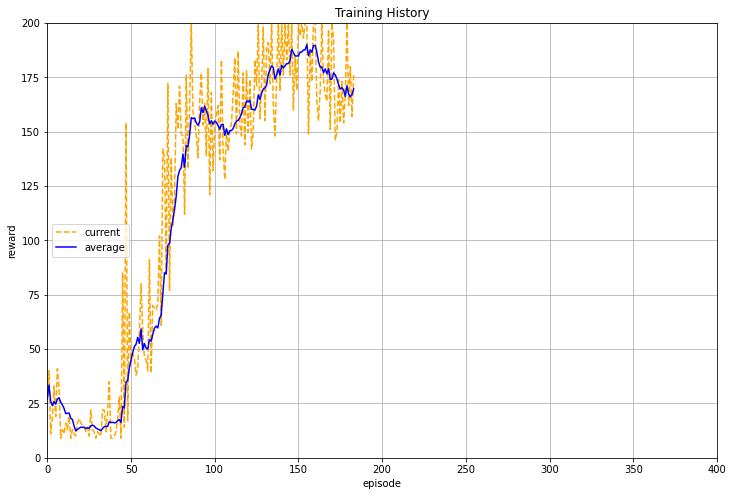

KeyboardInterrupt: 

In [6]:
gym_plotter = LivePlotter()
results = dqn_runner.run(env_name,
                         dqn.ClassicDQNLearner,
                         qn_keras.QNetwork,
                         layers=[64, 64],
                         n_episodes=2000,
                         epsilon=dqn_runner.basic_epsilon_linear(1, 0.05, 1000),
                         gamma=0.99,
                         n_mini_batch=64,
                         replay_db_warmup=1000,
                         replay_db_capacity=40000,
                         c_cycle=1,
                         polyak_rate=0.99,
                         averaging_window=10,
                         victory_threshold=196,
                         diagnostics_fn=gym_plotter.live_plot,
                         output_path=output_path_gym,
                         output_name=output_name_gym)


### pyAnsys environment in OpenAI: MAPDL in the loop
Now we do reinforcement learning with MAPDL in the loop as an OpenAI Gym package, thanks to the pyansys API:

<img src="media/ANSYS_loop.jpg" alt="Drawing" style="width: 600px;"/>
<center>Fig: A single iteration of the CartPole as a Markov Decision Process using MAPDL in pyansys</center>

In [5]:
import pyansys_cartpole

env_name = 'pyansys-CartPole-v0'

output_path_pyansys = os.path.join(os.getcwd(), 'pyansys_cartpole_results', str(uuid4())) 
output_name_pyansys = 'pyansys_cartpole_00'

if not os.path.exists(output_path_pyansys):
    os.makedirs(output_path_pyansys)
print(f'Writing model in: {output_path_pyansys}')

Writing model in: c:\Users\gayuso\Other_Projects\ML_RL_Cartpole\pyansys_cartpole_results\41249587-b528-4b9e-9a67-42b89f75c4b2


In [6]:
pyansys_plotter = LivePlotter()

results2 = dqn_runner.run(env_name,
                         dqn.ClassicDQNLearner,
                         qn_keras.QNetwork,
                         layers=[32, 32],
                         n_episodes=6000,
                         epsilon=dqn_runner.basic_epsilon_linear(1, 0.05, 1000),
                         gamma=0.99,
                         n_mini_batch=64, #64
                         replay_db_warmup=1000, #1000,
                         replay_db_capacity=40000,
                         c_cycle=1,
                         polyak_rate=0.99,
                         averaging_window=10,
                         victory_threshold=196,
                         diagnostics_fn=pyansys_plotter.live_plot,
                         output_path=output_path_pyansys,
                         output_name=output_name_pyansys)

ValueError: This is either an invalid get request, or MAPDL is set to the wrong processor (e.g. on BEGIN LEVEL vs. POST26)